# Grupo Bimbo Inventory Demand 

**_DESCRIPTION_**:
Planning a celebration is a balancing act of preparing just enough food to go around without being stuck eating the same leftovers for the next week. The key is `anticipating how many guests will come`. Grupo Bimbo must weigh similar considerations as it strives to meet daily consumer demand for fresh bakery products on the shelves of over 1 million stores along its 45,000 routes across Mexico.

Currently, daily inventory calculations are performed by direct delivery sales employees who must single-handedly predict the forces of supply, demand, and hunger based on their personal experiences with each store. With some breads carrying a one week shelf life, the acceptable margin for error is small.

In this competition, Grupo Bimbo invites Kagglers to develop a `model to accurately forecast inventory demand based on historical sales data`. Doing so will make sure consumers of its over 100 bakery products aren’t staring at empty shelves, while also reducing the amount spent on refunds to store owners with surplus product unfit for sale.

**_EVALUATION_**:
The evaluation metric for this competition is `Root Mean Squared Logarithmic Error`.

The RMSLE is calculated as:

$$\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$
Where:

ϵ is the RMSLE value (score)
n is the total number of observations in the (public/private) data set,
pi is your prediction of demand, and
ai is the actual demand for i.
log(x) is the natural logarithm of x
Submission File
For every row in the dataset, submission files should contain two columns: id and Demanda_uni_equi.  The id corresponds to the column of that id in the test.csv. The file should contain a header and have the following format:

**_DATA_**: https://www.kaggle.com/c/5260/download-all

### Load our libraries

In [1]:
# Data analysis and Wrangling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Operating System
import os

In [2]:
for f in os.listdir('./data'):
    print(f.ljust(30) + str(round(os.path.getsize('./data/' + f) / 1000000, 2)) + 'MB')

producto_tabla.csv            0.11MB
cliente_tabla.csv             21.25MB
.DS_Store                     0.01MB
test.csv                      251.11MB
town_state.csv                0.03MB
train.csv                     3199.36MB
sample_submission.csv         68.88MB


We have 6 datasets:

- train.csv — the training set
- test.csv — the test set
- sample_submission.csv — a sample submission file in the correct format
- cliente_tabla.csv — client names (can be joined with train/test on Cliente_ID)
- producto_tabla.csv — product names (can be joined with train/test on Producto_ID)
- town_state.csv — town and state (can be joined with train/test on Agencia_ID)

### Feature Exploration, Engineering and Cleaning

In [41]:
# Load in the train and test datasets
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv', nrows = 100_000)
cliente_tabla_df = pd.read_csv('./data/cliente_tabla.csv', nrows = 100_000)
producto_tabla_df = pd.read_csv('./data/producto_tabla.csv', nrows = 100_000)
town_state_df = pd.read_csv('./data/town_state.csv', nrows = 100_000)
sample_submission_df = pd.read_csv('./data/sample_submission.csv', nrows = 100_000)

In [4]:
# Demanda_uni_equil is the target value that we are trying to predict.
target = train_df['Demanda_uni_equil'].tolist()

- **train**

In [5]:
train_df.head()

Semana  Agencia_ID  Canal_ID  Ruta_SAK  Cliente_ID  Producto_ID  \
0       3        1110         7      3301       15766         1212   
1       3        1110         7      3301       15766         1216   
2       3        1110         7      3301       15766         1238   
3       3        1110         7      3301       15766         1240   
4       3        1110         7      3301       15766         1242   

   Venta_uni_hoy  Venta_hoy  Dev_uni_proxima  Dev_proxima  Demanda_uni_equil  
0              3      25.14                0          0.0                  3  
1              4      33.52                0          0.0                  4  
2              4      39.32                0          0.0                  4  
3              4      33.52                0          0.0                  4  
4              3      22.92                0          0.0                  3

In [6]:
train_df.describe()

Semana     Agencia_ID       Canal_ID      Ruta_SAK    Cliente_ID  \
count  100000.0  100000.000000  100000.000000  100000.00000  1.000000e+05   
mean        3.0    1111.166260       1.511530    1780.27560  1.173254e+06   
std         0.0       0.546718       1.761198     997.85845  1.488697e+06   
min         3.0    1110.000000       1.000000    1001.00000  1.407500e+04   
25%         3.0    1111.000000       1.000000    1101.00000  6.527800e+04   
50%         3.0    1111.000000       1.000000    1412.00000  4.188630e+05   
75%         3.0    1111.000000       1.000000    1642.00000  1.785102e+06   
max         3.0    1112.000000      11.000000    4501.00000  9.747286e+06   

         Producto_ID  Venta_uni_hoy      Venta_hoy  Dev_uni_proxima  \
count  100000.000000  100000.000000  100000.000000    100000.000000   
mean    14733.063630       6.649590      64.373366         0.091370   
std     17522.419476      18.487354     160.315317         3.995986   
min        72.000000       0.000000       0.000000         0.000000   
25%      1220.000000       2.000000      20.280000         0.000000   
50%      2233.000000       4.000000      37.500000         0.000000   
75%     32819.000000       7.000000      69.700000         0.000000   
max     49994.000000    2000.000000   15561.000000      1008.000000   

         Dev_proxima  Demanda_uni_equil  
count  100000.000000      100000.000000  
mean        0.902621           6.604250  
std        17.838545          18.486129  
min         0.000000           0.000000  
25%         0.000000           2.000000  
50%         0.000000           4.000000  
75%         0.000000           7.000000  
max      3030.880000        2000.000000

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
Semana               100000 non-null int64
Agencia_ID           100000 non-null int64
Canal_ID             100000 non-null int64
Ruta_SAK             100000 non-null int64
Cliente_ID           100000 non-null int64
Producto_ID          100000 non-null int64
Venta_uni_hoy        100000 non-null int64
Venta_hoy            100000 non-null float64
Dev_uni_proxima      100000 non-null int64
Dev_proxima          100000 non-null float64
Demanda_uni_equil    100000 non-null int64
dtypes: float64(2), int64(9)
memory usage: 8.4 MB


In [8]:
train_df.isnull().sum()

Semana               0
Agencia_ID           0
Canal_ID             0
Ruta_SAK             0
Cliente_ID           0
Producto_ID          0
Venta_uni_hoy        0
Venta_hoy            0
Dev_uni_proxima      0
Dev_proxima          0
Demanda_uni_equil    0
dtype: int64

In [9]:
train_df.isna().sum()

Semana               0
Agencia_ID           0
Canal_ID             0
Ruta_SAK             0
Cliente_ID           0
Producto_ID          0
Venta_uni_hoy        0
Venta_hoy            0
Dev_uni_proxima      0
Dev_proxima          0
Demanda_uni_equil    0
dtype: int64

Neither null nor missing values in the training dataset.

In [10]:
# Semana — Week number (From Thursday to Wednesday)
train_df.groupby('Semana')['Semana'].count()

Semana
3    100000
Name: Semana, dtype: int64

They are all from week ('semana') three.
Nevether, this is because it is a small portion of the dataset.
If we take a bigger one, we should have three to 9.
Therefore, this is likely a time series prediction problem.

In [11]:
# Agencia_ID — Sales Depot ID
train_df.groupby('Agencia_ID')['Agencia_ID'].count()

Agencia_ID
1110     8014
1111    67346
1112    24640
Name: Agencia_ID, dtype: int64

There are three agencies:
    - 1100
    - 1111
    - 1112

In [12]:
# Canal_ID — Sales Channel ID
train_df.groupby('Canal_ID')['Canal_ID'].count()

Canal_ID
1     91986
7      6931
8       421
11      662
Name: Canal_ID, dtype: int64

In [13]:
# Ruta_SAK — Route ID (Several routes = Sales Depot)
train_df.groupby('Ruta_SAK')['Ruta_SAK'].count().head()

Ruta_SAK
1001    1471
1002    1095
1003     927
1004     966
1005    1006
Name: Ruta_SAK, dtype: int64

In [14]:
# Cliente_ID — Client ID
train_df.groupby('Cliente_ID')['Cliente_ID'].count().head()

Cliente_ID
14075    68
14077     6
15766    23
16119     4
16127     1
Name: Cliente_ID, dtype: int64

In [15]:
# Venta_uni_hoy — Sales unit this week (integer)
train_df.groupby('Venta_uni_hoy')['Venta_uni_hoy'].count().head(10)

Venta_uni_hoy
0      414
1    13629
2    18445
3    12950
4     9982
5     9845
6     6609
7     3175
8     3994
9     2199
Name: Venta_uni_hoy, dtype: int64

In [16]:
# Venta_hoy — Sales this week (unit: pesos)
train_df.groupby('Venta_hoy')['Venta_hoy'].count().head(10)

Venta_hoy
0.00    414
0.50      3
1.50      2
1.66      1
2.50      2
3.02     35
3.70      4
3.75      2
3.89      1
4.00      1
Name: Venta_hoy, dtype: int64

In [17]:
# Dev_uni_proxima — Returns unit next week (integer)
train_df.groupby('Dev_uni_proxima')['Dev_uni_proxima'].count().head(10)

Dev_uni_proxima
0    97559
1     1179
2      563
3      220
4      126
5      109
6       54
7       31
8       24
9       16
Name: Dev_uni_proxima, dtype: int64

In [18]:
# Dev_proxima — Returns next week (unit: pesos)
train_df.groupby('Dev_proxima')['Dev_proxima'].count().head(10)

Dev_proxima
0.00    97559
3.02        6
3.70        3
3.75        5
3.84        1
4.44        6
4.50       12
4.54        1
4.58        1
4.63        1
Name: Dev_proxima, dtype: int64

In [19]:
# Demanda_uni_equil — Adjusted Demand (integer) (This is the target you will predict)
train_df.groupby('Demanda_uni_equil')['Demanda_uni_equil'].count().head(10)

Demanda_uni_equil
0     1307
1    13484
2    18190
3    12833
4     9892
5     9758
6     6567
7     3168
8     3975
9     2206
Name: Demanda_uni_equil, dtype: int64

-------------------------------

Which features are **categorical**?

- Categorical: Week Number.

Which features are **numeric**?

- Continous: Sales this week, Returns next week. Discrete: Sales unit this week, Returns unit next week.

-------------------------------

- **test**

In [20]:
test_df.head()

id  Semana  Agencia_ID  Canal_ID  Ruta_SAK  Cliente_ID  Producto_ID
0   0      11        4037         1      2209     4639078        35305
1   1      11        2237         1      1226     4705135         1238
2   2      10        2045         1      2831     4549769        32940
3   3      11        1227         1      4448     4717855        43066
4   4      11        1219         1      1130      966351         1277

In [21]:
test_df.describe()

id         Semana     Agencia_ID       Canal_ID  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    49999.500000      10.492880    2522.427680       1.401890   
std     28867.657797       0.499952    4048.241254       1.514251   
min         0.000000      10.000000    1110.000000       1.000000   
25%     24999.750000      10.000000    1311.000000       1.000000   
50%     49999.500000      10.000000    1613.000000       1.000000   
75%     74999.250000      11.000000    2034.000000       1.000000   
max     99999.000000      11.000000   25759.000000      11.000000   

            Ruta_SAK    Cliente_ID   Producto_ID  
count  100000.000000  1.000000e+05  100000.00000  
mean     2141.720180  1.820297e+06   22240.38086  
std      1503.610983  1.850008e+06   18692.34277  
min         1.000000  6.500000e+01      72.00000  
25%      1159.000000  3.570660e+05    1242.00000  
50%      1306.500000  1.207134e+06   31507.00000  
75%      2804.000000  2.391102e+06   40930.00000  
max      9824.000000  1.169326e+07   49994.00000

In [22]:
test_df.groupby('Semana')['Semana'].count()

Semana
10    50712
11    49288
Name: Semana, dtype: int64

### Visualisations

In [23]:
def label_plot(title, x, y):
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)

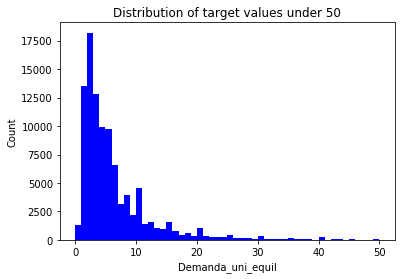

In [24]:
plt.hist(target, bins=50, color='blue', range=(0, 50))
label_plot('Distribution of target values under 50', 'Demanda_uni_equil', 'Count')
plt.show()

(0, 50)

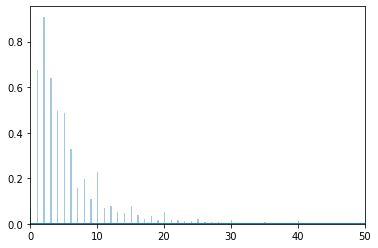

In [32]:
plt.clf()
sns.distplot(target, bins=10000)
plt.xlim(0, 50)

In [26]:
from collections import Counter
print(Counter(target).most_common(10))

[(2, 18190), (1, 13484), (3, 12833), (4, 9892), (5, 9758), (6, 6567), (10, 4578), (8, 3975), (7, 3168), (9, 2206)]


### Baseline

In [27]:
# Considering the fact that the most common value we found is 2, we can submit 2 as a baseline.

sample_submission_df['Demanda_uni_equil'] = 2
sample_submission_df.to_csv('mostcommon.csv', index=False)

### Using Facebook's Prophet

In [34]:
from fbprophet import Prophet

In [44]:
df_prophet = train_df[['Semana', 'Demanda_uni_equil']]
df_prophet = df_prophet.rename(columns={"Semana": "ds", "Demanda_uni_equil": "y"})

The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp

In [45]:
m = Prophet()
m.fit(df_prophet)

ValueError: Given date string not likely a datetime.

In [ ]:
future = m.make_future_dataframe(periods=2)
future.tail()

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)